# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 3. Визуальный анализ данных и построение признаков

## Часть 1. Построение признаков

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/home/leybal/projects/ds_course/hw09'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [14]:
import glob
import datetime

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    files = glob.glob(path_to_csv_files + '*.csv')
    files.sort()

    data = pd.read_pickle(site_freq_path)
    site_freq = pd.Series(data)

    train_data = pd.DataFrame()
    for feature_name in feature_names:
        train_data[feature_name] = []

    for i in range(len(files)):
        column = {}
        user_id = i + 1
        data = pd.read_csv(files[i])
        df = pd.DataFrame(data)

        steps_count = df['site'].size // window_size
        if df['site'].size < window_size:
            steps_count = 1
        elif df['site'].size % window_size != 0:
            steps_count = steps_count + 1

        for step in range(steps_count):
            date_list = []
            for site_index in range(session_length):
                index = step * window_size + site_index

                site_id = 0
                if index < df['site'].size:
                    site = df['site'][index]
                    site_id = site_freq[site][0]

                column['site' + str(site_index + 1)] = site_id

                if (index < df['timestamp'].size - 1) and (site_index < session_length - 1):
                    start = datetime.datetime.strptime(df['timestamp'][index], '%Y-%m-%d %H:%M:%S')
                    finish = datetime.datetime.strptime(df['timestamp'][index + 1], '%Y-%m-%d %H:%M:%S')
                    delta = finish - start
                    column['time_diff' + str(site_index + 1)] = delta.seconds
                    date_list.append(start)
                elif site_index < session_length - 1:
                    column['time_diff' + str(site_index + 1)] = 0

            if len(date_list) != 0:
                column['start_hour'] = min(date_list)
                column['day_of_week'] = column['start_hour'].weekday()
            else:
                column['start_hour'] = 0
                column['day_of_week'] = 0
            
            column['target'] = user_id
            train_data = train_data.append(column, ignore_index=True)

    for i, row in train_data.iterrows():
        train_data_row = train_data.loc[i]
        date_df = pd.DataFrame(train_data_row['time_diff1': 'time_diff9'])
        train_data['session_timespan'][i] = date_df.max() - date_df.min()
        train_data['#unique_sites'][i] = len(set(train_data_row['site1': 'site10']))

    return train_data

**Проверим функцию на игрушечном примере.**

In [15]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

train_data_toy = prepare_train_set_with_fe(PATH_TO_DATA + '/3users/', PATH_TO_DATA + '/site_freq_3users.pkl', feature_names, 10, 10)

In [16]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    4.0    2.0    2.0   11.0    2.0    1.0   10.0    6.0    9.0     8.0   
1    4.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0     0.0   
2    4.0    2.0    5.0    5.0    2.0    0.0    0.0    0.0    0.0     0.0   
3    3.0    1.0    2.0    1.0    2.0    1.0    1.0    6.0    7.0     3.0   
4    3.0    1.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0       287.0      1184.0      6278.0       186.0         2.0         1.0   
1         2.0         3.0        55.0         0.0         0.0         0.0   
2       287.0      1184.0      6278.0       186.0         0.0         0.0   
3       287.0      1184.0      6278.0       186.0         2.0         1.0   
4       287.0      1184.0         0.0         0.0         0.0         0.0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0         2.0         3.0        55.0            6277.0            8.0   
1         0.0         0.0         0.0              55.0            3.0   
2         0.0         0.0         0.0            6278.0            4.0   
3         2.0         3.0        55.0            6277.0            5.0   
4         0.0         0.0         0.0            1184.0            4.0   

           start_hour  day_of_week  target  
0 2013-11-15 09:28:17          4.0     1.0  
1 2013-11-15 12:40:35          4.0     1.0  
2 2013-11-15 09:28:17          4.0     2.0  
3 2013-11-15 09:28:17          4.0     3.0  
4 2013-11-15 12:28:17          4.0     3.0

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [17]:
%%time
train_data_10users = prepare_train_set_with_fe(PATH_TO_DATA + '/10users/', PATH_TO_DATA + '/site_freq_10users.pkl', feature_names, 10, 10)

CPU times: user 20min 11s, sys: 10.2 s, total: 20min 21s
Wall time: 20min 25s


In [18]:
train_data_10users.head()

site1   site2  site3   site4  site5  site6   site7   site8  site9  site10  \
0  192.0   575.0  134.0     3.0  134.0  134.0     3.0   134.0  203.0   134.0   
1  423.0   193.0  685.0   254.0  134.0   31.0   397.0  3668.0  218.0    55.0   
2   55.0     3.0   55.0    55.0    5.0  295.0   423.0   341.0  925.0    55.0   
3  476.0  3676.0  476.0    55.0   55.0   55.0    55.0   998.0  201.0   123.0   
4  347.0    55.0    5.0  3681.0  260.0  211.0  3684.0  2180.0  678.0  2180.0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0        10.0         0.0         0.0         1.0        20.0         1.0   
1         1.0         0.0       163.0       105.0         0.0         1.0   
2         0.0        14.0         1.0       242.0         0.0         0.0   
3         2.0         1.0         0.0         1.0        25.0         1.0   
4         1.0         0.0         1.0         1.0         1.0         0.0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0         0.0         1.0         0.0              20.0            5.0   
1         3.0         3.0         8.0             163.0           10.0   
2         1.0         0.0         0.0             242.0            7.0   
3         0.0         0.0         0.0              25.0            6.0   
4         1.0         1.0         0.0               1.0            9.0   

            start_hour  day_of_week  target  
0  2013-11-15 08:12:07          4.0     1.0  
1  2013-11-15 08:12:40          4.0     1.0  
2  2013-11-15 08:17:25          4.0     1.0  
3  2013-11-15 08:21:43          4.0     1.0  
4  2013-11-15 08:22:13          4.0     1.0

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [ ]:
%%time
train_data_150users = prepare_train_set_with_fe(PATH_TO_DATA + '/150users/', PATH_TO_DATA + '/site_freq_150users.pkl', feature_names, 10, 10)

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [20]:
new_features_10users = train_data_10users.loc[:,'session_timespan': 'day_of_week']
# new_features_150users = train_data_150users.loc[:,'session_timespan': 'day_of_week']

In [21]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
# with open(os.path.join(PATH_TO_DATA, 
#                        'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
#     pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [22]:
new_features_10users['session_timespan'].median()

14.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [23]:
new_features_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [24]:
import time

seconds = []
for i,row in new_features_10users.iterrows():
    if row['start_hour']:
        delta = (new_features_10users['start_hour'][i] - datetime.datetime(1970,1,1)).total_seconds()
        seconds.append(delta)

seconds_df = pd.Series(seconds)
seconds_df.median()

1392306833.5

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [25]:
new_features_10users['#unique_sites'].median()

6.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [4]:
data = pd.read_csv(PATH_TO_DATA + '/train_data_10users.csv')
train_data_10users = pd.DataFrame(data)
train_data_10users.rename(columns={'user_id': 'target'}, inplace=True)
new_features_10users_data = pd.read_pickle(PATH_TO_DATA + '/new_features_10users.pkl')
new_features_10users =  pd.DataFrame(new_features_10users_data)
train_data_10users = pd.concat([train_data_10users, new_features_10users], axis=1, sort=False)
print(train_data_10users.head())

# id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
#                33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)


   session_id  site1  site2  site3  site4  site5  site6  site7  site8  site9  \
0           0    192    575    134      3    134    134      3    134    203   
1           1    423    193    685    254    134     31    397   3668    218   
2           2     55      3     55     55      5    295    423    341    925   
3           3    476   3676    476     55     55     55     55    998    201   
4           4    347     55      5   3681    260    211   3684   2180    678   

   site10  target  session_timespan  #unique_sites           start_hour  \
0     134       1              20.0            5.0  2013-11-15 08:12:07   
1      55       1             163.0           10.0  2013-11-15 08:12:40   
2      55       1             242.0            7.0  2013-11-15 08:17:25   
3     123       1              25.0            6.0  2013-11-15 08:21:43   
4    2180       1               1.0            9.0  2013-11-15 08:22:13   

   day_of_week  
0          4.0  
1          4.0  
2          4.0  


In [5]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество сессий')

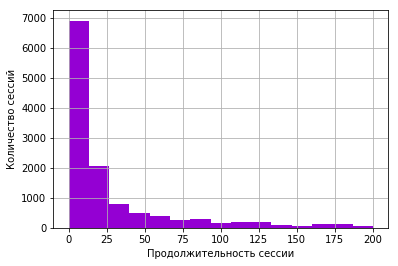

In [6]:
hist_session = train_data_10users['session_timespan'].hist(bins=15, range=(0, 200), color='darkviolet')

hist_session.set_xlabel('Продолжительность сессии')
hist_session.set_ylabel('Количество сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество сессий')

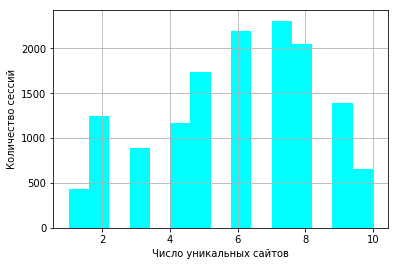

In [7]:
hist_session = train_data_10users['#unique_sites'].hist(bins=15, color='aqua')

hist_session.set_xlabel('Число уникальных сайтов')
hist_session.set_ylabel('Количество сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [8]:
# old_data_file = pd.read_csv(PATH_TO_DATA + '/train_data_10users.csv')
# old_data = pd.DataFrame(old_data_file)
# train_data_10users.target = old_data.user_id

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    loc_idx_x = idx // 4
    loc_idx_y = idx - (idx // 4) * 4
    axes[loc_idx_x, loc_idx_y].hist(sub_df['#unique_sites'], color=color_dic[user] )
    axes[loc_idx_x, loc_idx_y].set_title(str(user))
    axes[loc_idx_x, loc_idx_y].set_xlabel('Количество уникальных сайтов')
    axes[loc_idx_x, loc_idx_y].set_ylabel('Количество сессиий')
    


**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Начало сессии')

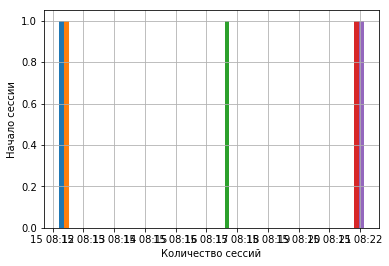

In [20]:
# print(train_data_10users['start_hour'])
# print(pd.groupby(train_data_10users, 'start_hour').head())
hist_start_hour = train_data_10users['start_hour'].head().hist()
hist_start_hour.set_xlabel('Количество сессий')
hist_start_hour.set_ylabel('Начало сессии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

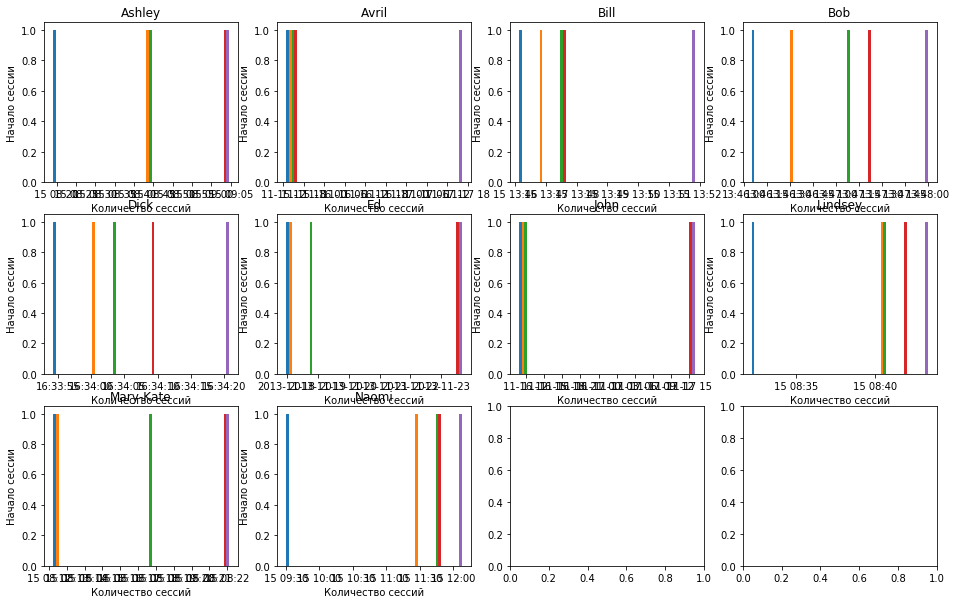

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    loc_idx_x = idx // 4
    loc_idx_y = idx - (idx // 4) * 4
    axes[loc_idx_x, loc_idx_y].hist(sub_df['start_hour'].head())
    axes[loc_idx_x, loc_idx_y].set_title(str(user))
    axes[loc_idx_x, loc_idx_y].set_xlabel('Количество сессий')
    axes[loc_idx_x, loc_idx_y].set_ylabel('Начало сессии')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'День недели')

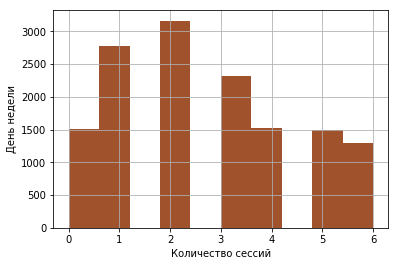

In [24]:
hist_day_of_week = train_data_10users['day_of_week'].hist(color='sienna')
hist_day_of_week.set_xlabel('Количество сессий')
hist_day_of_week.set_ylabel('День недели')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    loc_idx_x = idx // 4
    loc_idx_y = idx - (idx // 4) * 4
    axes[loc_idx_x, loc_idx_y].hist(sub_df['day_of_week'], color=color_dic[user] )
    axes[loc_idx_x, loc_idx_y].set_title(str(user))
    axes[loc_idx_x, loc_idx_y].set_xlabel('Количество сессий')
    axes[loc_idx_x, loc_idx_y].set_ylabel('День недели')
    axes[loc_idx_x, loc_idx_y].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''
Количество уникальных сайтов, которые посещают пользователи можно описать с помощью нормального распределения.
Каждый пользователь имеет свой паттерн посещения сайтов.


**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [36]:
site_freq_data = pd.read_pickle(PATH_TO_DATA + '/site_freq_10users.pkl')

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [112]:
top10_freqs = pd.DataFrame(site_freq_data)
top10_sites = top10_freqs[0:10]
top10_sites.index

Index(['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com',
       'www.facebook.com', 'apis.google.com',
       'r3---sn-gxo5uxg-jqbe.googlevideo.com',
       'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com',
       'accounts.google.com'],
      dtype='object')

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [160]:
site_freq = pd.DataFrame({'site': [], 'freq': []})
for i in range(10):
    site_freq = site_freq.append({'site': top10_sites.index[i], 'freq': top10_sites[0][i][1]}, ignore_index=True)

g = sns.barplot(x="site", y="freq", data=site_freq)
for item in g.get_xticklabels():
    item.set_rotation(90)


## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)